## Testing similarity scores filtering for GC/MS

To test the performance of the new filtering, Cosine Similarity score is computed with filter and unfilter spectra

## Adjusted filtering for GC/MS

The filters applied in the previous noteboooks were design for the use of LC/MS, however, due to the lack of parent mass in GC/MS and the better resolution in the scan, the filtering has been changed in ordered to obtain more peaks from the sample

## Testing a thousand pairs of filtered and unfiltered spectra

In order to test the new filtering in GC/MS, it is computed the Cosine similarity score of a thousand pairs of spectra from the same and different molecules

In [29]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

## Obtaining the data from the Mona File

In [30]:
from custom_functions.spectra_functions import get_data_folder_path

# from_external=False to use the data folder within the project
path = get_data_folder_path(from_external=False)
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Importing Spectra from msp

In [31]:
from matchms.importing import load_from_msp

spectrums = np.array([s for s in load_from_msp(msp_file)])
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


## Filters to apply to a subset of Spectra

Applied filters are:
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* normalize_intensities(s)
* select_by_relative_intensity(s, **intensity_from=0.05**, **intensity_to=0.1**)

Trying filtering relative intensities from 0.05 to 1

In [44]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def apply_my_filters(s):
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = normalize_intensities(s)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
    return s

## Selecting a sample of a thousand pairs of spectra of the same and different molecule

In [33]:
from custom_functions.spectra_functions import grouped_by_same_mol
from custom_functions.spectra_functions import grouped_by_diff_mol

same_mol_unfiltered = grouped_by_same_mol(spectrums, 1000)
diff_mol_unfiltered = grouped_by_diff_mol(spectrums, 1000)
print(len(same_mol_unfiltered), "spectra of the same molecule")
print(len(diff_mol_unfiltered), "spectra of different molecules")

9006 unique inchikeys
9006 unique inchikeys
1000 spectra of the same molecule
1000 spectra of different molecules


## Computing the Similarity score

The similarity algorithm used to test the new filtering is Cosine Greedy with Demuth "powers", because it was observed in the previous notebook that its performance was most similar to spec2vec scores.

In [34]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

def calculate_similarity_scores(spectrums, tolerance=0.1):
    
    similarity_measure = CosineGreedy(tolerance, 0.0, 0.33)
    similarity_scores, n_matches = [], []
    
    for s in spectrums:
        similarity_temp, n_matches_temp = similarity_measure(s[0], s[1])
        similarity_scores.append(similarity_temp)
        n_matches.append(n_matches_temp)
    
    return similarity_scores, n_matches

## Pairs of spectra of the same molecule
## Applying filters to the spectra and removing spectra without peaks

Applying the new filtering to the spectra.
Some spectra are left without peaks after filtering, in order to do a fair test, those spectra without peaks are removed from both spectra samples (filtered and unfiltered)

In [35]:
def filter_spectra(spectrums):
    temp_filtered, indexes_to_remove = [], []
    for k, spectrum in enumerate(spectrums):
        temp_filtered.append([apply_my_filters(s) for s in spectrum])
        # Always find is the new list has peaks intensities
        indexes_to_remove += [k for s in temp_filtered[-1] if len(s.peaks.intensities) <= 0]
    return temp_filtered, indexes_to_remove

same_mol_filtered, idx_to_remove = filter_spectra(same_mol_unfiltered)

same_mol_unfiltered = [s for k, s in enumerate(same_mol_unfiltered) if k not in idx_to_remove]
same_mol_filtered = [s for k, s in enumerate(same_mol_filtered) if k not in idx_to_remove]

print(f"{len(idx_to_remove)} indexes to delete: ", idx_to_remove)

0 indexes to delete:  []


## Pairs of spectra of different molecules
## Applying filters to the spectra and removing spectra without peaks

Applying the new filtering to the spectra.
Some spectra are left without peaks after filtering, in order to do a fair test, those spectra without peaks are removed from both spectra samples (filtered and unfiltered)

In [36]:

diff_mol_filtered, idx_to_remove = filter_spectra(diff_mol_unfiltered)

print(f"{len(idx_to_remove)} indexes without peaks after filtering")


diff_mol_unfiltered = [s for k, s in enumerate(diff_mol_unfiltered) if k not in idx_to_remove]
diff_mol_filtered = [s for k, s in enumerate(diff_mol_filtered) if k not in idx_to_remove]

print(len(diff_mol_unfiltered), " pairs of spectra of different molecule are remaining")


0 indexes without peaks after filtering
1000  pairs of spectra of different molecule are remaining


## Computing similarity scores for both groups of spectra with and without filtering

In [37]:

same_mol_similarities_unfiltered, same_mol_matches_unfiltered = calculate_similarity_scores(same_mol_unfiltered, 0.5)
diff_mol_similarities_unfiltered, diff_mol_matches_unfiltered = calculate_similarity_scores(diff_mol_unfiltered, 0.5)

same_mol_similarities_filtered, same_mol_matches_filtered = calculate_similarity_scores(same_mol_filtered, 0.5)
diff_mol_similarities_filtered, diff_mol_matches_filtered = calculate_similarity_scores(diff_mol_filtered, 0.5)


## Computing scores difference

Computing the difference in the scores of spectra with and without filtering

In [38]:

def compute_differences(unfiltered_spectra, filtered_spectra):
    assert len(unfiltered_spectra) == len(filtered_spectra), "The size of the lists need to be the same"
    
    difference_scores = []
    for i in range(len(unfiltered_spectra)):
        difference = abs(unfiltered_spectra[i] - filtered_spectra[i])
        # Sometimes spectra without peaks were used to compute similarity scores and the result was a NaN
        if np.isnan(difference):
            print(difference,i,  unfiltered_spectra[i], filtered_spectra[i])
        difference_scores.append(difference)
    return difference_scores

same_mol_score_differences = compute_differences(same_mol_similarities_unfiltered, same_mol_similarities_filtered)
diff_mol_score_differences = compute_differences(diff_mol_similarities_unfiltered, diff_mol_similarities_filtered)

print(f'Remaining Spectra of the same molecule: {len(same_mol_score_differences)}')
print(f'Remaining Spectra of different molecules: {len(diff_mol_score_differences)}')

Remaining Spectra of the same molecule: 1000
Remaining Spectra of different molecules: 1000


 ## Displaying boxplot of score difference of filtered and unfiltered spectra

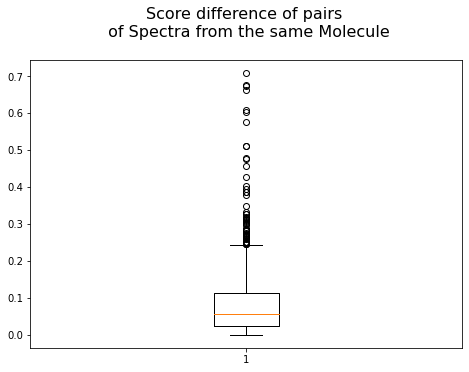

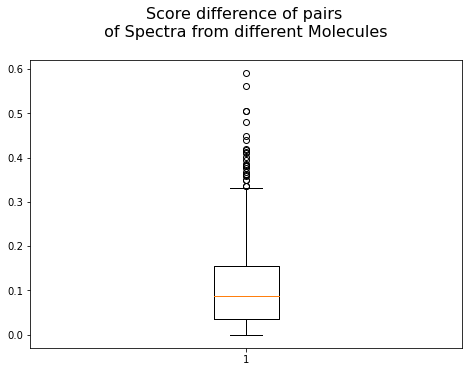

In [39]:
import matplotlib.pyplot as plt

def print_box_plot(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(title, fontsize=16)
    bp = ax.boxplot(data)
    plt.show()

print_box_plot(same_mol_score_differences, "Score difference of pairs \n of Spectra from the same Molecule\n")
print_box_plot(diff_mol_score_differences, "Score difference of pairs \n of Spectra from different Molecules \n")